# Import modules

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from pathlib import Path
from sklearn.metrics import roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_score

%cd /content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/
%pwd

pwd = Path.cwd()

/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction


#Import the data

In [2]:
# #Alternatively, Load a DataFrame of train.csv from pikl for better performance on import than import from csv

# #Define data paths
train_csv_path = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train.csv')
train_pkl_path = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/intermediate/train.pkl.gzip')

Using our insights gained from the EDA, when can import the data from csv with the best parameters for modelling.

In [3]:
# Read data from csv
# df = pd.read_csv(train_csv_path, index_col='row_id')

# in case the notebook instance crashes, so that we can quickly reload
# the dataframe and resume.
# df.to_pickle(train_pkl_path)

In [4]:
# # Or read data from pikl
# with open(train_pkl_path, 'rb') as f:
#   df = pickle.load(f)

# or, to read only a subset of the data:
#Define subset paths
# train_pkl_path_1_1 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_1.pkl.gzip')
# train_pkl_path_1_10 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_10.pkl.gzip')
# train_pkl_path_1_100 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_100.pkl.gzip')
# train_pkl_path_1_1000 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_1000.pkl.gzip')
train_pkl_path_1_10000 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_10000.pkl.gzip')
# train_pkl_path_1_100000 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_100000.pkl.gzip')
# train_pkl_path_1_1000000 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_1000000.pkl.gzip')
# train_pkl_path_1_10000000 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_10000000.pkl.gzip')

#Load the subsets
# with open( train_pkl_path_1_1, 'rb') as f:
#   df = pickle.load(f)
# with open( train_pkl_path_1_10, 'rb') as f:
#   df = pickle.load(f)
# with open( train_pkl_path_1_100, 'rb') as f:
#   df = pickle.load(f)
# with open( train_pkl_path_1_1000, 'rb') as f:
#   df = pickle.load(f)
with open( train_pkl_path_1_10000, 'rb') as f:
  df = pickle.load(f)
# with open( train_pkl_path_1_100000, 'rb') as f:
#   df = pickle.load(f)
# with open( train_pkl_path_1_1000000, 'rb') as f:
#   df = pickle.load(f)
# with open( train_pkl_path_1_10000000, 'rb') as f:
#   df = pickle.load(f)

# If using the subset pikl files, set the dtypes after


In [5]:
df

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0,115,5692,0,1,3,1,NaN,NaN
10000,2868613211,91216,1219,0,780,1,1,17000.0,True
20000,14686539127,220268,10656,0,1317,0,1,19000.0,True
30000,1083486476,650467,6857,0,243,3,1,11750.0,True
40000,15426935577,1084314,6798,0,1515,0,1,9000.0,False
...,...,...,...,...,...,...,...,...,...
101190000,1158534297,2146686585,383,0,300,0,0,20000.0,True
101200000,9269436738,2146925942,11859,0,163,1,1,26000.0,True
101210000,4609471378,2147012157,1202,0,1506,1,1,15000.0,True


In [6]:
df.dtypes

timestamp                           int64
user_id                             int64
content_id                          int64
content_type_id                     int64
task_container_id                   int64
user_answer                         int64
answered_correctly                  int64
prior_question_elapsed_time       float64
prior_question_had_explanation     object
dtype: object

In [7]:
# Define Target variable, and features
y = df.pop('answered_correctly')
X = df

X.shape, y.shape

((10124, 8), (10124,))

# Preprocessing: Transform data to fit classifier

Some classifier require variables in a certian form. Some classifiers cannot handle NA values. We will fix those in this section.

## Drop NA rows
Based on our earlier EDA, we have enough information to make informed decision on how to handle NA values.


In [8]:
# Count NA values
X.isna().sum()

timestamp                           0
user_id                             0
content_id                          0
content_type_id                     0
task_container_id                   0
user_answer                         0
prior_question_elapsed_time       222
prior_question_had_explanation     21
dtype: int64

Even though most data is not NA, recall that the data description showed that some data is "null" but were encoded as '-1' or other values. We'll encode them as NA instead.

In [9]:
# Convert Null values to NA

# Join X and y now, seperate them after 
X['answered_correctly'] = y
del y

# Reset index
X.reset_index(drop=True, inplace=True)

# Check NA counts before changes
print('\nX Before:\n', X.isna().sum())
# print('\ny Before:\n', y.isna().sum())

# content_type_id: "1 if the event was the user watching a lecture."
X['content_type_id'] = X['content_type_id'].mask(X['content_type_id']==1)


# user_answer: " Read -1 as null, for lectures."
X['user_answer'] = X['user_answer'].mask(X['user_answer']==-1)

# # answered_correctly Read -1 as null, for lectures
X['answered_correctly']= X['answered_correctly'].mask(X['answered_correctly']==-1)

# Count the NA entries after adding NA
print('\nX after adding NA:\n', X.isna().sum())

# Drop rows with NA 
X.dropna(inplace=True)

# Count the NA entries dropping adding NA
print('\nX after dropping NA:\n', X.isna().sum())

# Reset index
X.reset_index(drop=True, inplace=True)

# Seperate X and y
y = X.pop('answered_correctly')


X Before:
 timestamp                           0
user_id                             0
content_id                          0
content_type_id                     0
task_container_id                   0
user_answer                         0
prior_question_elapsed_time       222
prior_question_had_explanation     21
answered_correctly                  0
dtype: int64

X after adding NA:
 timestamp                           0
user_id                             0
content_id                          0
content_type_id                   201
task_container_id                   0
user_answer                       201
prior_question_elapsed_time       222
prior_question_had_explanation     21
answered_correctly                201
dtype: int64

X after dropping NA:
 timestamp                         0
user_id                           0
content_id                        0
content_type_id                   0
task_container_id                 0
user_answer                       0
prior_question_ela

In the before and after printouts, we see the effect of masking the null-encoded values, and replacing them with NA.

In [10]:
X.shape, y.shape

((9902, 8), (9902,))

We see that the .shape attribute shows that about 2% of the entries were dropped. But we also see that X and y dropped different numbers of rows.

In [11]:
X

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation
0,2868613211,91216,1219,0.0,780,1.0,17000.0,True
1,14686539127,220268,10656,0.0,1317,0.0,19000.0,True
2,1083486476,650467,6857,0.0,243,3.0,11750.0,True
3,15426935577,1084314,6798,0.0,1515,0.0,9000.0,False
4,8841108363,1282581,10294,0.0,988,2.0,31500.0,True
...,...,...,...,...,...,...,...,...
9897,1158534297,2146686585,383,0.0,300,0.0,20000.0,True
9898,9269436738,2146925942,11859,0.0,163,1.0,26000.0,True
9899,4609471378,2147012157,1202,0.0,1506,1.0,15000.0,True
9900,689004,2147192385,6880,0.0,14,2.0,44000.0,False


In [12]:
y

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
9897    0.0
9898    1.0
9899    1.0
9900    0.0
9901    0.0
Name: answered_correctly, Length: 9902, dtype: float64

## Set the correct dtypes
A droping the NA values, we can properly set some categorical featueres as boolean features to save memory.

In [13]:
#Check dtypes before
X.dtypes

timestamp                           int64
user_id                             int64
content_id                          int64
content_type_id                   float64
task_container_id                   int64
user_answer                       float64
prior_question_elapsed_time       float64
prior_question_had_explanation     object
dtype: object

In [14]:
#Check dtypes before
y.dtypes

dtype('float64')

In [15]:
categorical_columns = ['user_id', 'content_id', 'content_type_id', 'task_container_id', 'user_answer']
for column_id in categorical_columns:
  X[column_id] = pd.Categorical(X[column_id])
  
boolean_columns = ['prior_question_had_explanation']
for column_id in boolean_columns:
  X[column_id] = X[column_id].astype(bool)

y = y.astype(bool)

In [16]:
#Check dtypes after
X.dtypes

timestamp                            int64
user_id                           category
content_id                        category
content_type_id                   category
task_container_id                 category
user_answer                       category
prior_question_elapsed_time        float64
prior_question_had_explanation        bool
dtype: object

In [17]:
#Check dtypes after
y.dtype

dtype('bool')

## Drop features that don't predict the target variable

In the EDA, we learned that 'user_id' and 'content_type_id' do not predict the target variable.

In [18]:
# Drop 'user_id' and 'content_type_id'
X.drop(columns=['user_id', 'content_type_id'], inplace=True)
X

,timestamp,content_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation
0,2868613211,1219,780,1.0,17000.0,True
1,14686539127,10656,1317,0.0,19000.0,True
2,1083486476,6857,243,3.0,11750.0,True
3,15426935577,6798,1515,0.0,9000.0,False
4,8841108363,10294,988,2.0,31500.0,True
...,...,...,...,...,...,...
9897,1158534297,383,300,0.0,20000.0,True
9898,9269436738,11859,163,1.0,26000.0,True
9899,4609471378,1202,1506,1.0,15000.0,True
9900,689004,6880,14,2.0,44000.0,False


## Transform the data

### Encode the categorical variables

The categorical variables need to be one-hot-encoded for most of the models to work correctly.

The numerical variables may need to be standardized for some models.


We see the row count is unchanged, but now there's many more columns due to how we changed all the categorical data into numerical data.

In [19]:
# Check the dtypes
X.dtypes

timestamp                            int64
content_id                        category
task_container_id                 category
user_answer                       category
prior_question_elapsed_time        float64
prior_question_had_explanation        bool
dtype: object

In [20]:
# Seperate the categorical and numerical variables
X_cat = X.select_dtypes(['category'])
X_num = X.select_dtypes(['int64', 'float64'])
X_bool = X.select_dtypes(['bool'])

#Save the column labels for later
X_cat_columns = X_cat.columns
X_num_columns = X_num.columns
# X_bool_columns = X_bool.columns

In [21]:
X

,timestamp,content_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation
0,2868613211,1219,780,1.0,17000.0,True
1,14686539127,10656,1317,0.0,19000.0,True
2,1083486476,6857,243,3.0,11750.0,True
3,15426935577,6798,1515,0.0,9000.0,False
4,8841108363,10294,988,2.0,31500.0,True
...,...,...,...,...,...,...
9897,1158534297,383,300,0.0,20000.0,True
9898,9269436738,11859,163,1.0,26000.0,True
9899,4609471378,1202,1506,1.0,15000.0,True
9900,689004,6880,14,2.0,44000.0,False


In [22]:
X_bool

,prior_question_had_explanation
0,True
1,True
2,True
3,False
4,True
...,...
9897,True
9898,True
9899,True
9900,False


In [23]:
pd.get_dummies(X_cat, sparse=False)

,content_id_0,content_id_1,content_id_2,content_id_3,content_id_4,content_id_5,content_id_6,content_id_7,content_id_8,content_id_9,content_id_10,content_id_12,content_id_14,content_id_15,content_id_18,content_id_19,content_id_23,content_id_24,content_id_25,content_id_26,content_id_28,content_id_30,content_id_31,content_id_33,content_id_36,content_id_37,content_id_39,content_id_42,content_id_43,content_id_45,content_id_50,content_id_51,content_id_52,content_id_55,content_id_56,content_id_58,content_id_59,content_id_60,content_id_61,content_id_62,...,task_container_id_8328,task_container_id_8340,task_container_id_8461,task_container_id_8544,task_container_id_8600,task_container_id_8615,task_container_id_8689,task_container_id_8735,task_container_id_8769,task_container_id_8852,task_container_id_8867,task_container_id_8891,task_container_id_8914,task_container_id_8972,task_container_id_8993,task_container_id_9024,task_container_id_9076,task_container_id_9080,task_container_id_9145,task_container_id_9148,task_container_id_9157,task_container_id_9181,task_container_id_9187,task_container_id_9218,task_container_id_9229,task_container_id_9276,task_container_id_9289,task_container_id_9308,task_container_id_9458,task_container_id_9471,task_container_id_9695,task_container_id_9703,task_container_id_9742,task_container_id_9936,task_container_id_9953,task_container_id_9975,user_answer_0.0,user_answer_1.0,user_answer_2.0,user_answer_3.0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9897,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9898,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
9899,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
9900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [24]:
# Prepare your categorical data using LabelEncoder()
from sklearn.preprocessing import LabelEncoder

# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
le = LabelEncoder()

# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
X_cat_le = X_cat.apply(le.fit_transform)
X_cat_le

,content_id,task_container_id,user_answer
0,793,771,1
1,4946,1255,0
2,3446,242,3
3,3397,1398,0
4,4763,964,2
...,...,...,...
9897,250,299,0
9898,5186,162,1
9899,780,1393,1
9900,3465,13,2


In [25]:
# Apply OneHotEncoder() on Dataframe
from sklearn.preprocessing import OneHotEncoder

# TODO: create a OneHotEncoder object, and fit it to all of X

# 1. INSTANTIATE
enc = OneHotEncoder(drop='first', dtype=bool)

# 2. FIT
enc.fit(X_cat_le)

# 3. Transform
X_cat_encoded = enc.transform(X_cat_le)
X_cat_encoded

# as you can see, you've the same number of rows 891
# but now you've so many more columns due to how we changed all the categorical data into numerical data

<9902x8065 sparse matrix of type '<class 'numpy.bool_'>'
	with 26906 stored elements in Compressed Sparse Row format>

In [26]:
enc.categories_

[array([   0,    1,    2, ..., 5282, 5283, 5284]),
 array([   0,    1,    2, ..., 2776, 2777, 2778]),
 array([0, 1, 2, 3])]

In [27]:
# Take a look at X_cat_encoded's shape
X_cat_encoded.shape

(9902, 8065)

In [28]:
# Make a dataframe fopr X_cat_encoded                    

X_cat_encoded_df = pd.DataFrame.sparse.from_spmatrix(X_cat_encoded)
X_cat_encoded_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8025,8026,8027,8028,8029,8030,8031,8032,8033,8034,8035,8036,8037,8038,8039,8040,8041,8042,8043,8044,8045,8046,8047,8048,8049,8050,8051,8052,8053,8054,8055,8056,8057,8058,8059,8060,8061,8062,8063,8064
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9897,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9898,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
9899,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
9900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Standardize the numerical variables.



In [29]:
# Check dtypes
X_num.dtypes

timestamp                        int64
prior_question_elapsed_time    float64
dtype: object

In [30]:
# Check for normality on numerical features
from scipy.stats import kstest

for feature in X_num.columns:
  statistic, p = kstest(X_num[feature], 'norm')
  print(f"\n{feature}:\nStatistic: {statistic:0.5f}, p_value: {p:0.5f}")
  print('Probably gaussian.') if p>0.05 else print('Probably not gaussian.') 


timestamp:
Statistic: 1.00000, p_value: 0.00000
Probably not gaussian.

prior_question_elapsed_time:
Statistic: 0.99828, p_value: 0.00000
Probably not gaussian.


We see that none of the numerical features are normally distributed. Let's standardize them using the StandardScaler.

In [31]:
from sklearn.preprocessing import StandardScaler
 
# Instantiate scaler object
scaler = StandardScaler()

# Fit: Compute the mean and std to be used for later scaling.
# And tranform
X_num_scaled = scaler.fit_transform(X_num)
X_num_scaled

array([[-0.41411096, -0.42315151],
       [ 0.61734447, -0.32505444],
       [-0.56991483, -0.68065633],
       ...,
       [-0.26217079, -0.52124859],
       [-0.66442019,  0.90115899],
       [-0.66441337, -0.52124859]])

In [32]:
# Check the old vs new mean
np.mean(X_num, axis=0), np.mean(X_num_scaled, axis=0)

(timestamp                      7.613300e+09
 prior_question_elapsed_time    2.562720e+04
 dtype: float64, array([2.47563365e-17, 8.53914215e-17]))

In [33]:
# Check the old vs new standard deviation
np.std(X_num, axis=0), np.std(X_num_scaled, axis=0)

(timestamp                      1.145752e+10
 prior_question_elapsed_time    2.038797e+04
 dtype: float64, array([1., 1.]))

As expected, the X_new means are zero, and the standard deviations are 1.

In [34]:
# Make a dataframe for X_num
X_num_scaled_df = pd.DataFrame(X_num_scaled, columns=X_num_columns)
X_num_scaled_df

,timestamp,prior_question_elapsed_time
0,-0.414111,-0.423152
1,0.617344,-0.325054
2,-0.569915,-0.680656
3,0.681965,-0.815540
4,0.107162,0.288052
...,...,...
9897,-0.563365,-0.276006
9898,0.144546,0.018285
9899,-0.262171,-0.521249
9900,-0.664420,0.901159


### Combine the transformed features into one transformed dataframe.

In [35]:
#Make sure the shapes are compatible
assert X_cat_encoded_df.shape[0] == X_num_scaled_df.shape[0]
assert X_cat_encoded_df.shape[0] == X_bool.shape[0]
X_cat_encoded_df.shape, X_num_scaled_df.shape, X_bool.shape


((9902, 8065), (9902, 2), (9902, 1))

The number of rows is the same.

In [36]:
# Make sure all the indexes are the same
X_cat_encoded_df.index, X_num_scaled_df.index, X_bool.index

(RangeIndex(start=0, stop=9902, step=1),
 RangeIndex(start=0, stop=9902, step=1),
 RangeIndex(start=0, stop=9902, step=1))

The indexes are the same.

In [37]:
# Create the combined dataframe
X = pd.DataFrame(
          X_bool).join(
          X_cat_encoded_df).join(
          X_num_scaled_df)
X

,prior_question_had_explanation,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,8027,8028,8029,8030,8031,8032,8033,8034,8035,8036,8037,8038,8039,8040,8041,8042,8043,8044,8045,8046,8047,8048,8049,8050,8051,8052,8053,8054,8055,8056,8057,8058,8059,8060,8061,8062,8063,8064,timestamp,prior_question_elapsed_time
0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.414111,-0.423152
1,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.617344,-0.325054
2,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.569915,-0.680656
3,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.681965,-0.815540
4,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.107162,0.288052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9897,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.563365,-0.276006
9898,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.144546,0.018285
9899,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.262171,-0.521249
9900,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.664420,0.901159


In [38]:
# Make sure there is no NA values
X.isna().sum()

prior_question_had_explanation    0
0                                 0
1                                 0
2                                 0
3                                 0
                                 ..
8062                              0
8063                              0
8064                              0
timestamp                         0
prior_question_elapsed_time       0
Length: 8068, dtype: int64

In [39]:
# Chec k dtypes on last time.
X.dtypes

prior_question_had_explanation               bool
0                                 Sparse[bool, 0]
1                                 Sparse[bool, 0]
2                                 Sparse[bool, 0]
3                                 Sparse[bool, 0]
                                       ...       
8062                              Sparse[bool, 0]
8063                              Sparse[bool, 0]
8064                              Sparse[bool, 0]
timestamp                                 float64
prior_question_elapsed_time               float64
Length: 8068, dtype: object

##  Define the preprocessing functions, one each for train data and test data

In [40]:
def preprocess_data(X_unpreprocessed, 
                          y_unpreprocessed, 
                          test_data=False, 
                          fitted_encoder=None, 
                          fitted_scaler=None):
  ## Convert Null values to NA
  # Join X and y now, seperate them after
  X = X_unpreprocessed.copy()
  del X_unpreprocessed
  X['answered_correctly'] = y_unpreprocessed
  del y_unpreprocessed

  # Reset index
  X.reset_index(drop=True, inplace=True)

  # Check NA counts before changes
  # print('\nX Before:\n', X.isna().sum())
  # print('\ny Before:\n', y.isna().sum())

  # content_type_id: "1 if the event was the user watching a lecture."
  X['content_type_id'] = X['content_type_id'].mask(X['content_type_id']==1)


  # user_answer: " Read -1 as null, for lectures."
  X['user_answer'] = X['user_answer'].mask(X['user_answer']==-1)

  # # answered_correctly Read -1 as null, for lectures
  X['answered_correctly']= X['answered_correctly'].mask(X['answered_correctly']==-1)

  # Count the NA entries after adding NA
  # print('\nX after adding NA:\n', X.isna().sum())

  # Drop rows with NA 
  X.dropna(inplace=True)

  # Count the NA entries dropping adding NA
  # print('\nX after dropping NA:\n', X.isna().sum())

  # Reset index
  X.reset_index(drop=True, inplace=True)

  # Seperate X and y
  y = X.pop('answered_correctly')

  categorical_columns = ['user_id', 'content_id', 'content_type_id', 'task_container_id', 'user_answer']
  for column_id in categorical_columns:
    X[column_id] = pd.Categorical(X[column_id])
    
  boolean_columns = ['prior_question_had_explanation']
  for column_id in boolean_columns:
    X[column_id] = X[column_id].astype(bool)

  y = y.astype(bool)

  # Drop 'user_id' and 'content_type_id'
  X.drop(columns=['user_id', 'content_type_id'], inplace=True)

  # Seperate the categorical and numerical variables
  X_cat = X.select_dtypes(['category'])
  X_num = X.select_dtypes(['int64', 'float64'])
  X_bool = X.select_dtypes(['bool'])

  #Save the column labels for later
  X_cat_columns = X_cat.columns
  X_num_columns = X_num.columns
  # X_bool_columns = X_bool.columns

  if test_data==False:
    # Apply OneHotEncoder() on Dataframe
    from sklearn.preprocessing import OneHotEncoder
    # 1. INSTANTIATE
    enc = OneHotEncoder(dtype=bool, handle_unknown='ignore', sparse=True)
    # 2. FIT
    enc.fit(X_cat)
    # 3. Transform
    X_cat_encoded = enc.transform(X_cat)

    from sklearn.preprocessing import StandardScaler
    # Instantiate scaler object
    scaler = StandardScaler()
    # Fit And tranform
    X_num_scaled = scaler.fit_transform(X_num)
  
  else: # if test_data=True
    # Apply fitted OneHotEncoder()
    X_cat_encoded = fitted_encoder.transform(X_cat)
    # Apply fitted StandardScaler()
    X_num_scaled = fitted_scaler.transform(X_num)
  

  # Make a dataframe for X_cat_encoded                    
  X_cat_encoded_df = pd.DataFrame.sparse.from_spmatrix(X_cat_encoded)

  # Make a dataframe for X_num_scaled
  X_num_scaled_df = pd.DataFrame(X_num_scaled, columns=X_num_columns)

  #Make sure the shapes are compatible
  assert X_cat_encoded_df.shape[0] == X_num_scaled_df.shape[0]
  assert X_cat_encoded_df.shape[0] == X_bool.shape[0]

  # Create the combined dataframe
  X = pd.DataFrame(
            X_bool).join(
            X_cat_encoded_df).join(
            X_num_scaled_df)
  # For train data return the fitted label_encoder object, 
  # fitted one_hot_encoder object and 
  # fitted standard_scaler object as well as the transformed data
  if test_data==False:
    return X, y, enc, scaler
  else:
    return X, y

## Define the Split_data_and_process_data function

In [41]:
# Define a function  to make train test splits and preprocess data
from sklearn.model_selection import train_test_split

def make_splits_and_preprocess(X, y, test_size=0.20, random_state=42):
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y, 
                                                      test_size=test_size, 
                                                      random_state=random_state,
                                                      stratify=y)
  del X
  del y
  X_train, y_train, encoder, scaler = preprocess_data(X_train, 
                                                      y_train, 
                                                      test_data=False)
  X_test, y_test = preprocess_data(X_test, 
                                   y_test, 
                                   test_data=True,
                                   fitted_encoder=encoder, 
                                   fitted_scaler=scaler)
  
  return X_train, X_test, y_train, y_test


# Baseline Modelling

## Import fresh data

In [42]:
# Read data from csv
# df = pd.read_csv(train_csv_path, index_col='row_id')

# in case the notebook instance crashes, so that we can quickly reload
# the dataframe and resume.
# df.to_pickle(train_pkl_path)

In [43]:
# Or read data from pikl
# with open(train_pkl_path, 'rb') as f:
#   df = pickle.load(f)

# or, to read only a subset of the data:
#Define subset paths
train_pkl_path_1_1 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_1.pkl.gzip')
train_pkl_path_1_10 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_10.pkl.gzip')
train_pkl_path_1_100 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_100.pkl.gzip')
train_pkl_path_1_1000 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_1000.pkl.gzip')
train_pkl_path_1_10000 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_10000.pkl.gzip')
train_pkl_path_1_100000 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_100000.pkl.gzip')
train_pkl_path_1_1000000 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_1000000.pkl.gzip')
train_pkl_path_1_10000000 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_10000000.pkl.gzip')

#Load the subsets
# with open( train_pkl_path_1_1, 'rb') as f:
#   df = pickle.load(f)
# with open( train_pkl_path_1_10, 'rb') as f:
#   df = pickle.load(f)
# with open( train_pkl_path_1_100, 'rb') as f:
#   df = pickle.load(f)
# with open( train_pkl_path_1_1000, 'rb') as f:
#   df = pickle.load(f)
with open( train_pkl_path_1_10000, 'rb') as f:
  df = pickle.load(f)
# with open( train_pkl_path_1_100000, 'rb') as f:
#   df = pickle.load(f)
# with open( train_pkl_path_1_1000000, 'rb') as f:
#   df = pickle.load(f)
# with open( train_pkl_path_1_10000000, 'rb') as f:
#   df = pickle.load(f)

# If using the subset pikl files, set the dtypes after

# Define Target variable, and features
y = df.pop('answered_correctly')
X = df

## Make Train Test Splits and Preprocess each split

In [53]:
# Make Train Test Splits and Preprocess each split
X_train, X_test, y_train, y_test = train_test_split(
                                    X, 
                                    y, 
                                    test_size=0.20, 
                                    random_state=42,
                                    stratify=y)

# Preprocess train data
X_train, y_train, enc, scaler = preprocess_data(X_train, 
                                                y_train, 
                                                test_data=False)

# Preprocess test data
X_test, y_test = preprocess_data(X_test,
                                 y_test,
                                 test_data=True,
                                 fitted_encoder=enc,
                                 fitted_scaler=scaler)

# Make sure the shapes are right
assert X_train.shape[0]==y_train.shape[0]
assert X_test.shape[0]==y_test.shape[0]
assert X_train.shape[1]==X_test.shape[1]

# Check the shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7922, 7138), (1980, 7138), (7922,), (1980,))

## Decision Tree

dt_clf_2 cross_val_score roc_auc mean: 0.5382
dt_clf_2 cross_val_score roc_auc std (%): 1.3


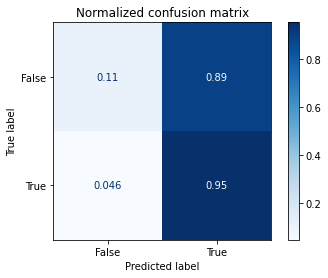

In [73]:
from sklearn import tree

# Instantiate classifier object
dt_clf = tree.DecisionTreeClassifier(max_depth=2)

# Fit classifier
dt_clf = dt_clf.fit(X_train, y_train)

#CV Score
dt_clf_cv_roc_auc = cross_val_score(dt_clf, 
                                           X_train, 
                                           y_train, 
                                           scoring="roc_auc", 
                                           cv = 5)
dt_clf_cv_roc_auc_mean = np.mean(dt_clf_cv_roc_auc)
dt_clf_cv_roc_auc_std_perc = 100*np.std(dt_clf_cv_roc_auc)/dt_clf_cv_roc_auc_mean

#Print mean and std of cv_auc_scores
print(f'dt_clf_2 cross_val_score roc_auc mean: {dt_clf_cv_roc_auc_mean:0.4}')
print(f'dt_clf_2 cross_val_score roc_auc std (%): {dt_clf_cv_roc_auc_std_perc:0.2}')

# Plot normalized confusion matrix
disp = plot_confusion_matrix(dt_clf, X_test, y_test,
                              cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title("Normalized confusion matrix")
plt.show()

## Logistic Regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training roc_auc_score: 0.94766
Testing roc_auc_score: 0.59004


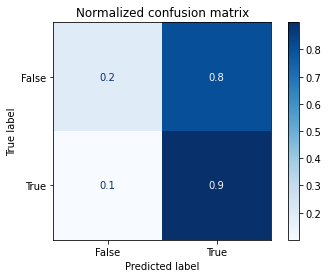

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix

# Instantiate classifier object
log_reg = LogisticRegression()

# Fit classifier
log_reg.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_preds = log_reg.predict(X_train)
y_test_preds = log_reg.predict(X_test)

#Score the predictions
log_reg_train_roc_score = roc_auc_score(y_train, y_train_preds)
log_reg_test_roc_score = roc_auc_score(y_test, y_test_preds)

print(f"Training roc_auc_score: {log_reg_train_roc_score:0.5f}")
print(f"Testing roc_auc_score: {log_reg_test_roc_score:0.5f}")

# Plot normalized confusion matrix
disp = plot_confusion_matrix(log_reg, X_test, y_test,
                              cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title("Normalized confusion matrix")
plt.show()

That's a pretty bad score for a baseline model. It's good in training, and terrible in test.


## LightGBM

Training roc_auc_score: 0.55420
Testing roc_auc_score: 0.55821


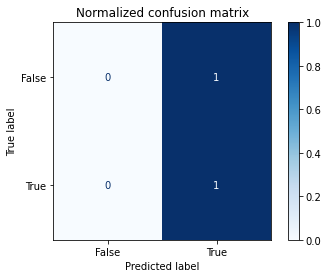

In [48]:
from lightgbm import LGBMClassifier

# Instantiate the classifier object
lgbm = LGBMClassifier(
    num_leaves=31, 
    max_depth= 2, 
    n_estimators = 25, 
    min_child_samples = 1000, 
    subsample=0.7, 
    subsample_freq=5,
    n_jobs= -1,
    is_higher_better = True,
    first_metric_only = True
)

# Fit the classifier object to the train data
lgbm.fit(np.array(X_train), np.array(y_train))

# Make predictions on the train and test sets
y_train_preds = lgbm.predict(np.array(X_train))
y_test_preds = lgbm.predict(np.array(X_test))

#Score the predictions
lgbm_train_roc_score = roc_auc_score(y_train, y_train_preds)
lgbm_test_roc_score = roc_auc_score(y_test, y_test_preds)

print(f"Training roc_auc_score: {lgbm_train_roc_score:0.5f}")
print(f"Testing roc_auc_score: {lgbm_test_roc_score:0.5f}")

# Plot normalized confusion matrix
disp = plot_confusion_matrix(lgbm, np.array(X_test), 
                             np.array(y_test),
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title("Normalized confusion matrix")
plt.show()

We see that the LGBM baseline is better than the logistic regression model baseline.

## K-Nearest-Neighbors Classifier

 K-Nearest-Neighbors Classifier is not a good choice for a model. KNN requires that each feature be continuous, but our categorical features are discrete.

Training roc_auc_score: 0.69251
Testing roc_auc_score: 0.59156


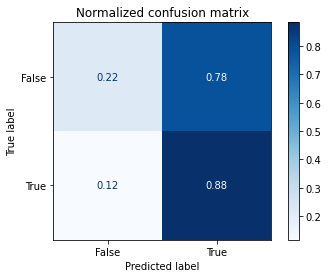

In [51]:
from sklearn.neighbors import KNeighborsClassifier

# Instantiate the classifier object
knn = KNeighborsClassifier(n_neighbors=20)

# Fit the classifier object to the train data
knn.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_preds = knn.predict(X_train)
y_test_preds = knn.predict(X_test)

#Score the predictions
knn_train_roc_score = roc_auc_score(y_train, y_train_preds)
knn_test_roc_score = roc_auc_score(y_test, y_test_preds)

print(f"Training roc_auc_score: {knn_train_roc_score:0.5f}")
print(f"Testing roc_auc_score: {knn_test_roc_score:0.5f}")

# Plot normalized confusion matrix
disp = plot_confusion_matrix(knn, X_test, y_test,
                              cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title("Normalized confusion matrix")
plt.show()

## Section Summary

We tested three baseline models: Logistic Regression, LightGBM, and K-Nearest Neighbors. Each model is from a different class of models and they each have their trade-offs and assumptions.

Logistic Regression performed well intraining and poorly in testing.

K-Nearest-Neighbors performed great in training but worst of all three models on the test data. This is evidence that the model baseline tuning is over-fitting on noise in the training data.

LightGBM performed the worst with the baseline hyperparameters. It assigned the target variable the same value for all inputs. It did not learn anything from training. I'll have to adjust the code on this model.



We see that the baseline K-Nearest-Neighbors Classifier did quite well on the training set, but very poorly on the test set. KNN takes the longest to run. I'll have to adjust the hyper parameters or do some feature engineering to reduce the number of columns. Also, as the KNN took about 20 times longer to run than the other models, it makes sense that it's mch better.


In [50]:
#Training and test roc_scores
print(f"dt_clf_train_roc_score: {dt_clf_train_roc_score:0.5f}")
print(f"dt_clf_test_roc_score: {dt_clf_test_roc_score:0.5f}")

print(f"log_reg_train_roc_score: {log_reg_train_roc_score:0.5f}")
print(f"log_reg_test_roc_score: {log_reg_test_roc_score:0.5f}")

print(f"lgbm_train_roc_score: {lgbm_train_roc_score:0.5f}")
print(f"lgbm_test_roc_score: {lgbm_test_roc_score:0.5f}")

print(f"knn_train_roc_score: {knn_train_roc_score:0.5f}")
print(f"knn_test_roc_score: {knn_test_roc_score:0.5f}")

dt_clf_train_roc_score: 0.53938
dt_clf_test_roc_score: 0.53248
log_reg_train_roc_score: 0.94766
log_reg_test_roc_score: 0.59004
lgbm_train_roc_score: 0.55420
lgbm_test_roc_score: 0.55821


NameError: ignored

` adfsdf`

In [ ]:
How large is your training set?
If your training set is small, high bias/low variance classifiers (e.g., Naive Bayes) have an advantage over low bias/high variance classifiers (e.g., kNN), since the latter will overfit. But low bias/high variance classifiers start to win out as your training set grows (they have lower asymptotic error), since high bias classifiers aren’t powerful enough to provide accurate models.

You can also think of this as a generative model vs. discriminative model distinction.

Advantages of some particular algorithms
Advantages of Naive Bayes: Super simple, you’re just doing a bunch of counts. If the NB conditional independence assumption actually holds, a Naive Bayes classifier will converge quicker than discriminative models like logistic regression, so you need less training data. And even if the NB assumption doesn’t hold, a NB classifier still often does a great job in practice. A good bet if want something fast and easy that performs pretty well. Its main disadvantage is that it can’t learn interactions between features (e.g., it can’t learn that although you love movies with Brad Pitt and Tom Cruise, you hate movies where they’re together).

Advantages of Logistic Regression: Lots of ways to regularize your model, and you don’t have to worry as much about your features being correlated, like you do in Naive Bayes. You also have a nice probabilistic interpretation, unlike decision trees or SVMs, and you can easily update your model to take in new data (using an online gradient descent method), again unlike decision trees or SVMs. Use it if you want a probabilistic framework (e.g., to easily adjust classification thresholds, to say when you’re unsure, or to get confidence intervals) or if you expect to receive more training data in the future that you want to be able to quickly incorporate into your model.

Advantages of Decision Trees: Easy to interpret and explain (for some people – I’m not sure I fall into this camp). They easily handle feature interactions and they’re non-parametric, so you don’t have to worry about outliers or whether the data is linearly separable (e.g., decision trees easily take care of cases where you have class A at the low end of some feature x, class B in the mid-range of feature x, and A again at the high end). One disadvantage is that they don’t support online learning, so you have to rebuild your tree when new examples come on. Another disadvantage is that they easily overfit, but that’s where ensemble methods like random forests (or boosted trees) come in. Plus, random forests are often the winner for lots of problems in classification (usually slightly ahead of SVMs, I believe), they’re fast and scalable, and you don’t have to worry about tuning a bunch of parameters like you do with SVMs, so they seem to be quite popular these days.

Advantages of SVMs: High accuracy, nice theoretical guarantees regarding overfitting, and with an appropriate kernel they can work well even if you’re data isn’t linearly separable in the base feature space. Especially popular in text classification problems where very high-dimensional spaces are the norm. Memory-intensive, hard to interpret, and kind of annoying to run and tune, though, so I think random forests are starting to steal the crown.

But…
Recall, though, that better data often beats better algorithms, and designing good features goes a long way. And if you have a huge dataset, then whichever classification algorithm you use might not matter so much in terms of classification performance (so choose your algorithm based on speed or ease of use instead).

And to reiterate what I said above, if you really care about accuracy, you should definitely try a bunch of different classifiers and select the best one by cross-validation. Or, to take a lesson from the Netflix Prize (and Middle Earth), just use an ensemble method to choose them all.